In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
pip install quandl

     |████████████████████████████████| 61 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 4.5 MB/s eta 0:00:011
     |████████████████████████████████| 136 kB 3.5 MB/s eta 0:00:01
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
     |████████████████████████████████| 58 kB 4.9 MB/s eta 0:00:011
     |████████████████████████████████| 509 kB 7.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install cvxportfolio

     |████████████████████████████████| 230 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 835 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 770 kB/s eta 0:00:01
     |████████████████████████████████| 158 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 34 kB/s  eta 0:00:01
     |████████████████████████████████| 829 kB 3.3 MB/s eta 0:00:01
  Created wheel for scs: filename=scs-2.1.2-cp36-cp36m-macosx_10_14_x86_64.whl size=119124 sha256=7828a93b03b60cf6f579884b87c4c9fa5af3d7a50f142e3b7f1b65db0f82e314
  Stored in directory: /Users/ashleyzhuang/Library/Caches/pip/wheels/50/02/c2/0708708e215645196adc1ea78c7dc776b173a37a86deb6a7e7
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=2f61d3488d8fc683a79a7fb180624671c3e26998304953f58cbbda16af1d428a
  Stored in directory: /Users/ashleyzhuang/Library/Caches/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
Successfully built s

In [4]:
pip install yahoo_fin

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install requests_html

     |████████████████████████████████| 145 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 8.5 MB/s  eta 0:00:01
     |████████████████████████████████| 115 kB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 4.3 MB/s eta 0:00:01
  Created wheel for parse: filename=parse-1.18.0-py3-none-any.whl size=24133 sha256=24e0c563851ee542fc96dfeed84a476fc21a8d429febf8d5b74a6878070c002f
  Stored in directory: /Users/ashleyzhuang/Library/Caches/pip/wheels/85/db/d9/2416d9d65785454955833a9272db1df200ee64f2269cf6e282
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=864f80aea6a1ebb0502760c9c0ce0d046c5c8493fee88c8cfe124891c0109886
  Stored in directory: /Users/ashleyzhuang/Library/Caches/pip/wheels/19/f5/6d/a97dd4f22376d4472d5f4c76c7646876052ff3166b3cf71050
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13487 sha256=e7670bc045b04990b8d79e999fb992ef6c52f7e92f2ac8de5401f60a34c7878e
  Stored in

In [9]:
pip install multiprocess

     |████████████████████████████████| 101 kB 1.2 MB/s ta 0:00:01
     |████████████████████████████████| 81 kB 1.1 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl
import yahoo_fin.stock_info as si

import cvxportfolio as cp

/Users/ashleyzhuang/Desktop/quant-optimizer/cvxportfolio/policies.py:42: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  def get_trades(self, portfolio, t=pd.datetime.today()):
/Users/ashleyzhuang/Desktop/quant-optimizer/cvxportfolio/policies.py:60: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  def get_trades(self, portfolio, t=pd.datetime.today()):
/Users/ashleyzhuang/Desktop/quant-optimizer/cvxportfolio/policies.py:74: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  def get_trades(self, portfolio, t=pd.datetime.today()):
/Users/ashleyzhuang/Desktop/quant-optimizer/cvxportfolio/policies.py:107: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from

In [11]:
import importlib
importlib.reload(cp)

<module 'cvxportfolio' from '/Users/ashleyzhuang/Desktop/quant-optimizer/cvxportfolio/__init__.py'>

Download the problem data from Quandl. We select four liquid stocks, and the risk-free rate.

# Universe
We define the universe of tradeable assets for HFAC. HFAC only trades micro-cap and small-cap equities (<$5 billion market cap).

In [ ]:
ticker_data = {}
for ticker in si.tickers_dow():
  ticker_data[ticker] = si.get_quote_table(ticker)
ticker_data

In [ ]:
for ticker, ticker_info in ticker_data.items():
  print(f'{ticker} Market Cap: {ticker_info["Market Cap"]}')

AAPL Market Cap: 2.036T
AMGN Market Cap: 138.06B
AXP Market Cap: 84.469B
BA Market Cap: 94.461B
CAT Market Cap: 91.379B
CRM Market Cap: 235.28B
CSCO Market Cap: 170.015B
CVX Market Cap: 140.314B
DIS Market Cap: 229.153B
DOW Market Cap: 36.537B
GS Market Cap: 70.952B
HD Market Cap: 309.654B
HON Market Cap: 122.714B
IBM Market Cap: 112.151B
INTC Market Cap: 230.342B
JNJ Market Cap: 389.921B
JPM Market Cap: 309.423B
KO Market Cap: 214.901B
MCD Market Cap: 170.675B
MMM Market Cap: 98.482B
MRK Market Cap: 201.909B
MSFT Market Cap: 1.662T
NKE Market Cap: 200.938B
PG Market Cap: 359.476B
TRV Market Cap: 28.692B
UNH Market Cap: 313.516B
V Market Cap: 439.659B
VZ Market Cap: 240.214B
WBA Market Cap: 32.394B
WMT Market Cap: 410.072B


In [44]:
tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2020-11-20'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date, api_key='ic1Q96b-rnXN1X1czyMi')['Adj. Close'].pct_change())
                             for ticker in tickers]))
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date, api_key='ic1Q96b-rnXN1X1czyMi')/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,TSLA,NKE,USDOLLAR
Date,,,,,
2018-03-21,-0.002931,-0.001643,0.019256,-0.006737,0.000068
2018-03-22,-0.023871,-0.037340,-0.023473,-0.029088,0.000068
2018-03-23,-0.031436,-0.025258,-0.024458,0.003260,0.000068
2018-03-26,0.040319,0.026828,0.008755,0.019650,0.000070
2018-03-27,-0.037799,-0.044731,-0.082188,0.004097,0.000070


In [46]:
amzn_data = quandl.get('WIKI/AMZN', start_date=start_date, end_date=end_date, api_key='ic1Q96b-rnXN1X1czyMi')

We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [49]:
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna()

r_hat.tail()

,AMZN,GOOGL,TSLA,NKE,USDOLLAR
Date,,,,,
2018-03-21,0.002640,0.001090,0.001124,0.000705,0.000046
2018-03-22,0.002605,0.001085,0.001132,0.000960,0.000046
2018-03-23,0.002513,0.000984,0.001042,0.000736,0.000046
2018-03-26,0.002395,0.000904,0.000813,0.000678,0.000046
2018-03-27,0.002551,0.000996,0.000740,0.000787,0.000046


# Transaction Costs and Holding Costs

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [51]:
tcost_model=cp.TcostModel(half_spread=10E-4) # need: sigma, volumes (source from api)
hcost_model=cp.HcostModel(borrow_costs=1E-4) # need: dividends (source from api)

# Trading and Holding Constraints

In [72]:
long_only = cp.LongOnly()
leverage_limit=cp.LeverageLimit(1)
# max_trade = cp.MaxTrade(, max_fraction=0.15)

# Risk Model

In [73]:
risk_model = cp.FullSigma(Sigma_hat.reset_index(level=1, drop=True))

# Full Optimization Policy

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [74]:
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit, long_only])

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [75]:
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2013-01-03',  end_time='2016-12-31',  
                               policies=[spo_policy, cp.Hold()], parallel=False)
results[0].summary()

Number of periods                              1007
Initial timestamp               2013-01-03 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                         23.011
Excess return (%)                            22.895
Excess risk (%)                              19.125
Sharpe ratio                                  1.198
Max. drawdown                                19.860
Turnover (%)                                 54.248
Average policy time (sec)                     0.034
Average simulator time (sec)                  0.003


The total value of the portfolio in time.

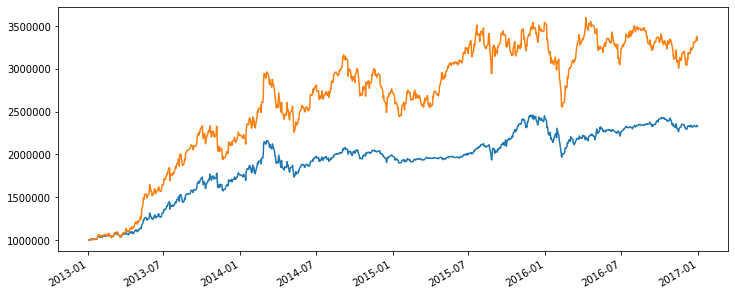

In [70]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))

The weights vector of the portfolio in time.

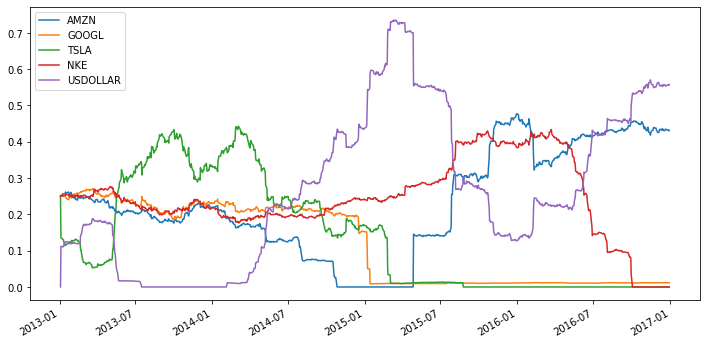

In [71]:
results[0].w.plot(figsize=(12,6))